In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
import brian2 as b2

from utils.custom_sounds import Tone
from utils.log import logger
from cochleas.hrtf_utils import run_hrtf
from cochleas.consts import ITD_REMOVAL_STRAT
import logging

2025-01-11 00:58:36,952 [INFO ]  

>>>>> start execution


# ILD only

approssimazione: puntiamo all'effetto di una HRTF, solo in termini di ILD. Questo significa:
- passare il suono in input in una HRTF esistente -> `GammatoneCochlea.run_hrtf`
- analizzare i due lati per identificare qual è l'ITD -> `analyze.sound_analysis.itd`
- anticipare il lato che sente il suono in ritardo per allinearlo all'altro -> basarsi su `HeadlessDatabase`

Il risultato di questa operazione sarà, però, che il momento in cui "i due suoni arrivano alle ANF" (o più propriamente: il momento in cui il segnale mostra l'effetto dei suoni) cambierà tra una posizione e l'altra. Se questo non ci piace, si può risolvere, per ora puntiamo a ottenere l'effetto sperato.


WARNING    /home/paolo/Documents/school/master/polimi/thesis/polithesis/src/analyze/sound_analysis.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


when computing ITD
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz


WARNING    /home/paolo/Documents/school/master/polimi/thesis/polithesis/src/analyze/sound_analysis.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, [left_plot, right_plot] = plt.subplots(2, 1)
 [py.warnings]


Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz


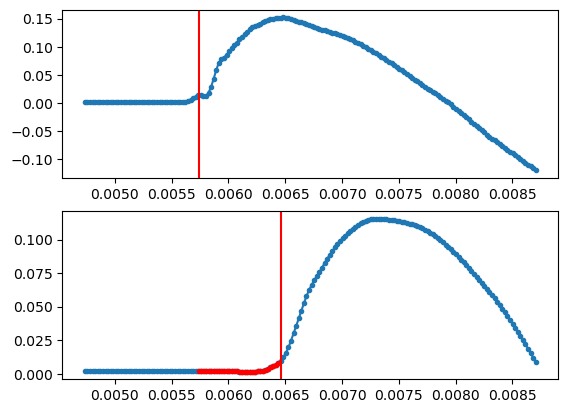

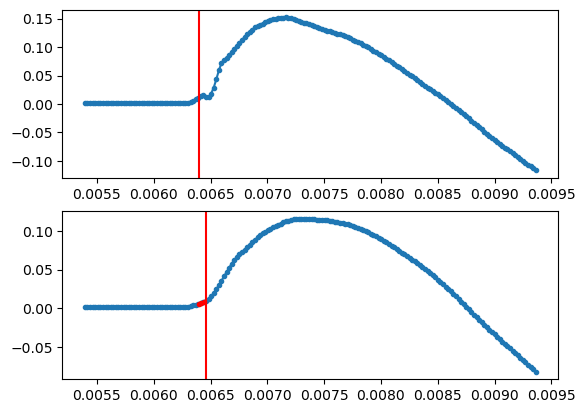

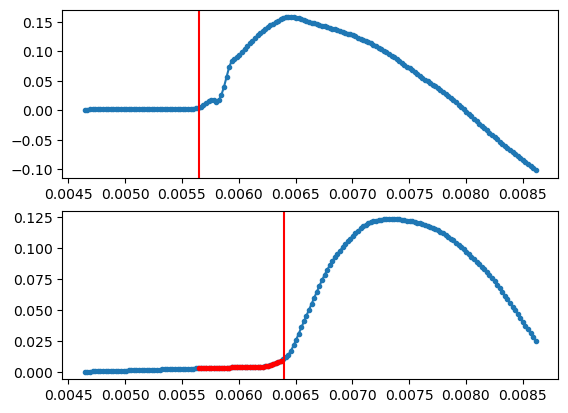

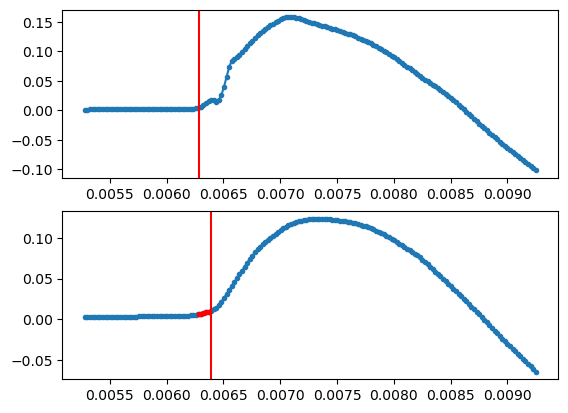

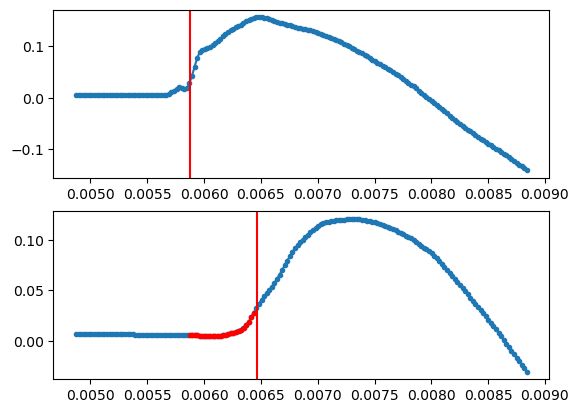

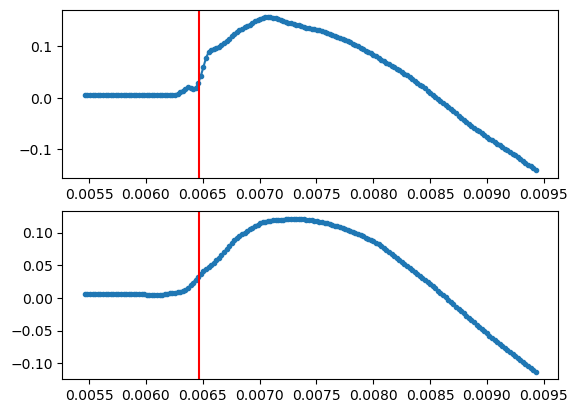

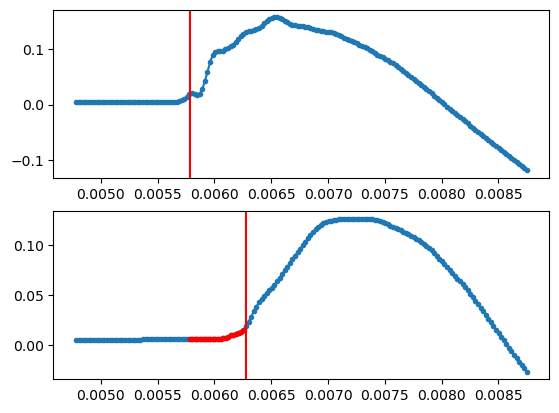

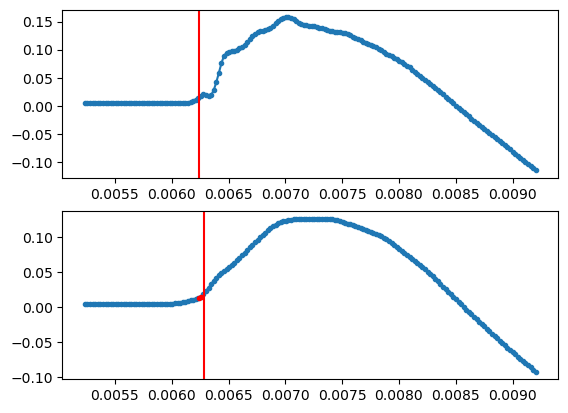

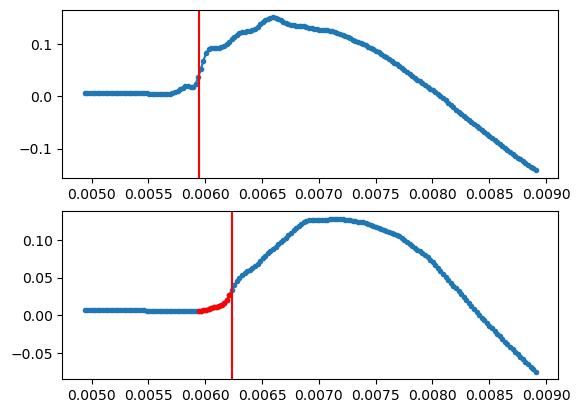

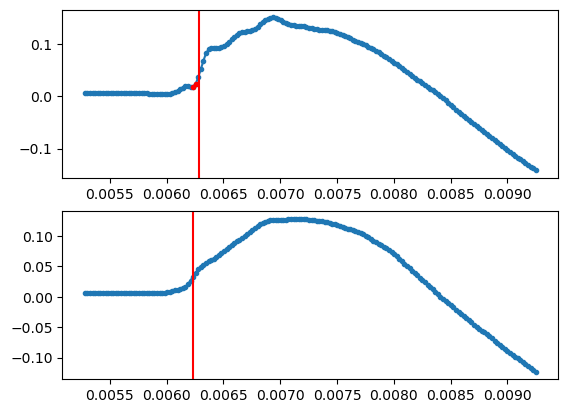

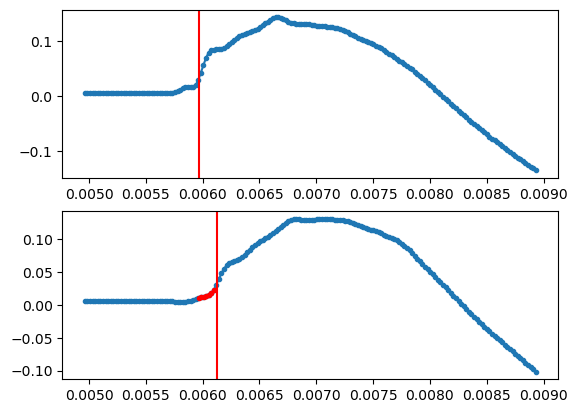

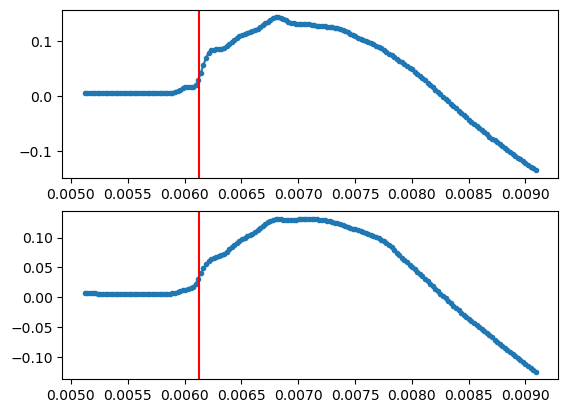

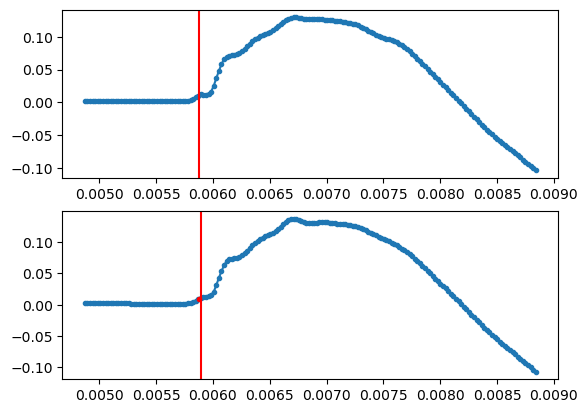

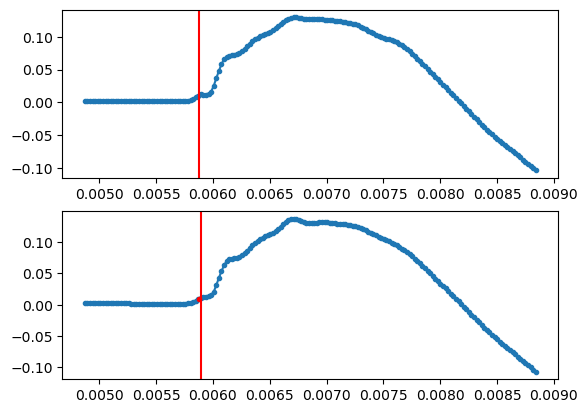

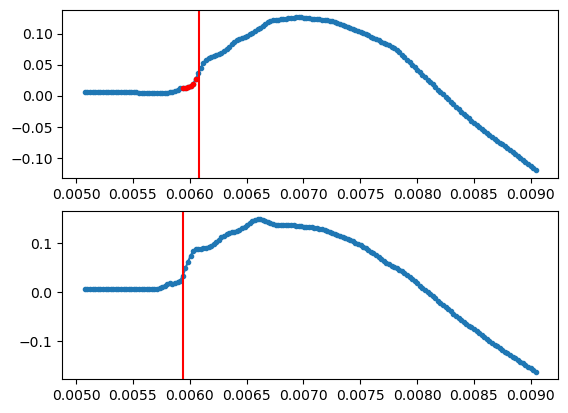

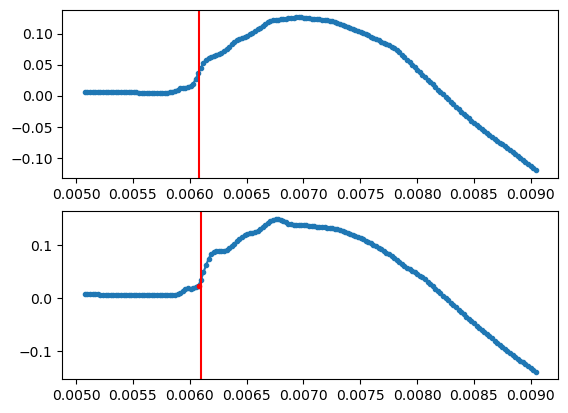

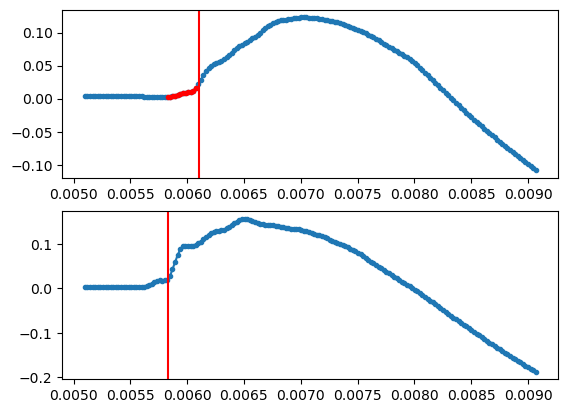

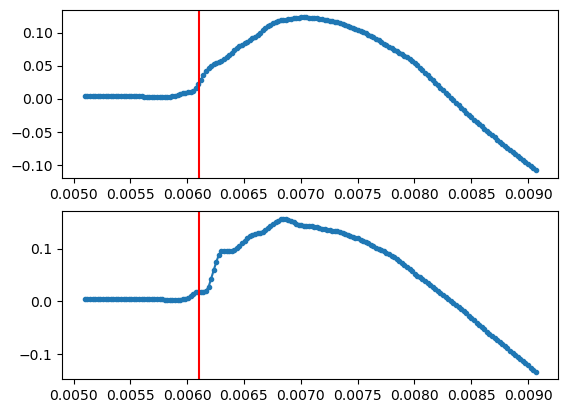

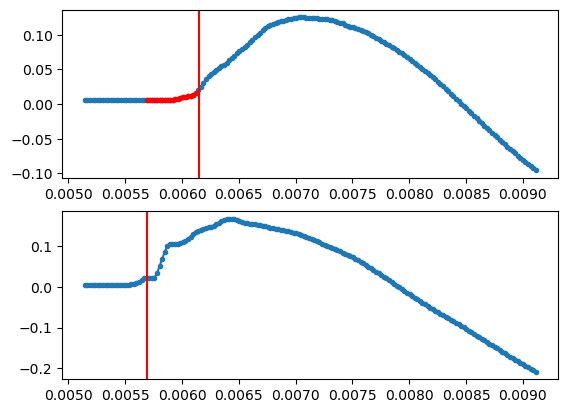

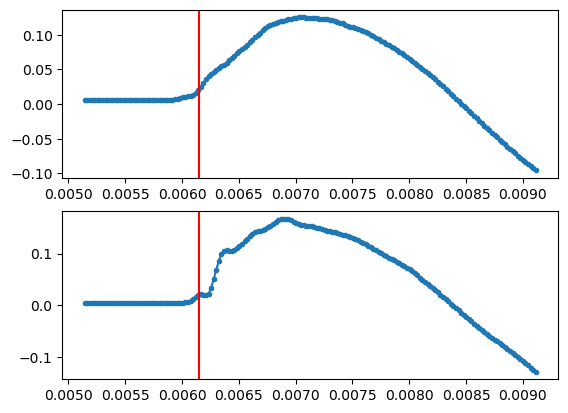

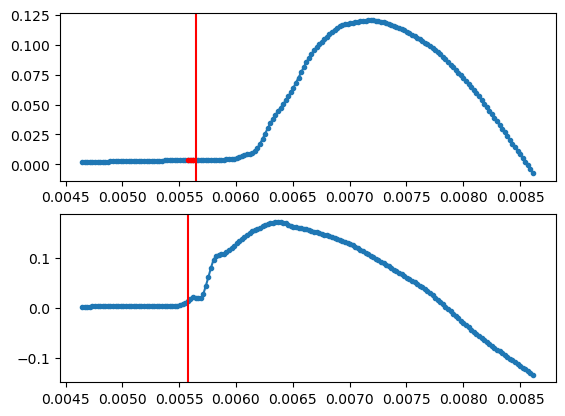

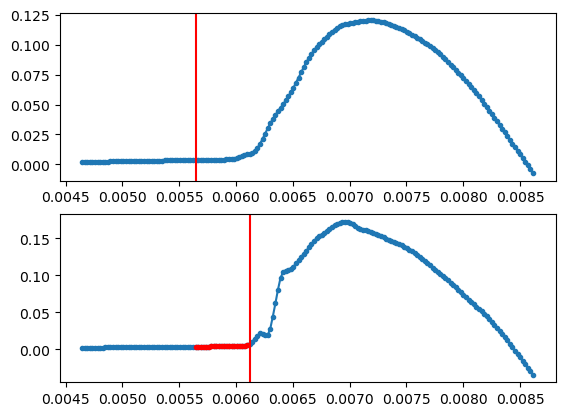

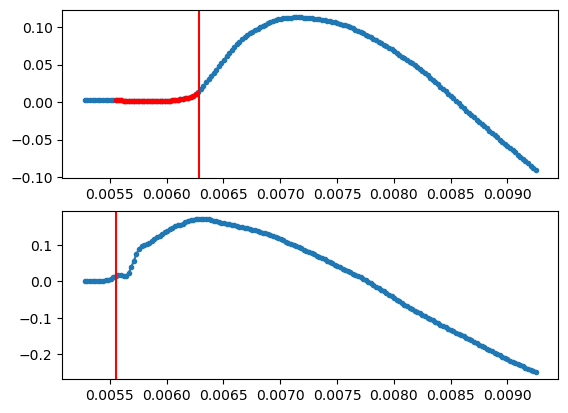

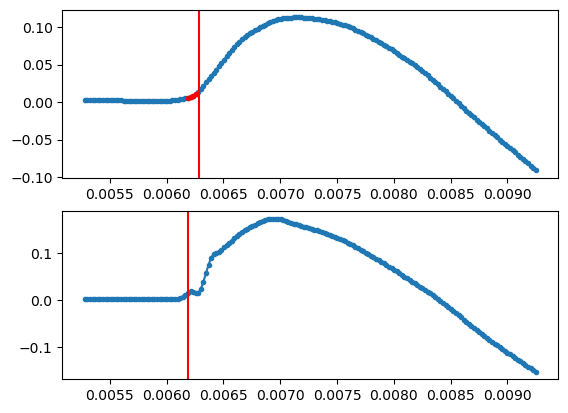

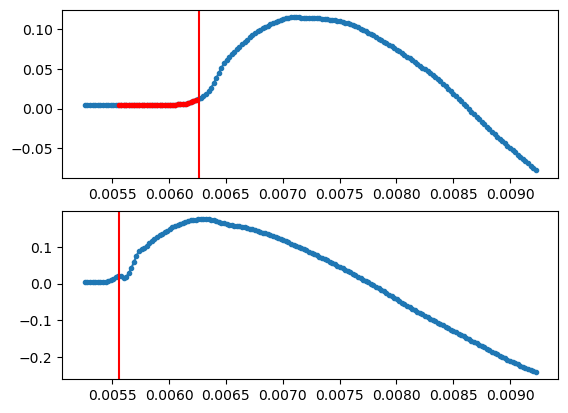

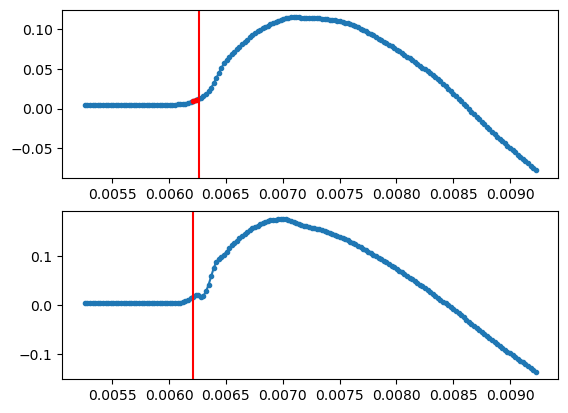

In [2]:
sound = Tone(100 * b2.Hz, 50 * b2.ms)
ANGLE = -30
print("when computing ITD")
for ANGLE in range(-90,91,15):
    logger.setLevel(logging.WARNING)
    itd = run_hrtf(sound,ANGLE,{
                        "subj_number": 7,
                        "ild_only": True,
                        "itd_remove_strategy": ITD_REMOVAL_STRAT.COMPUTED,
                        "show_ITD_plots": True
                    }, )
    print(itd)

WHEN USING HRTF ESTIMATE
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz
Sound duration 50. ms, channels 2, samplerate 44.1 kHz


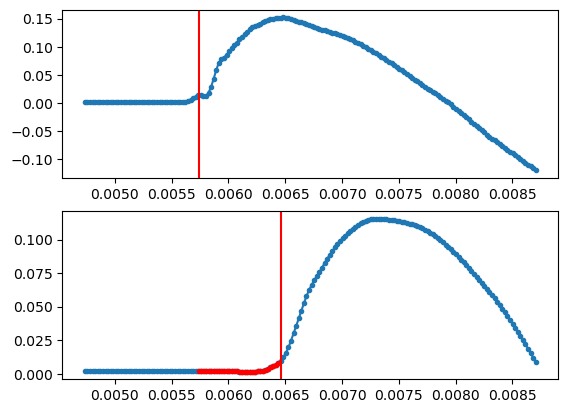

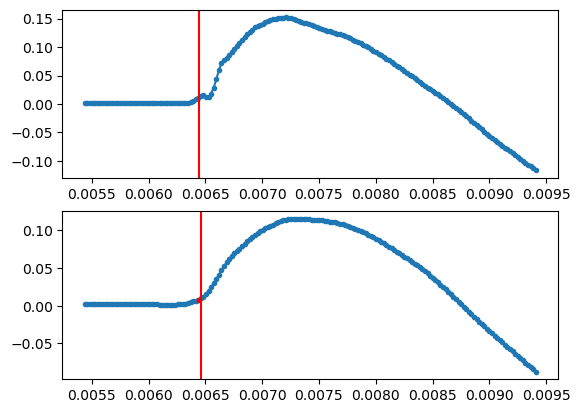

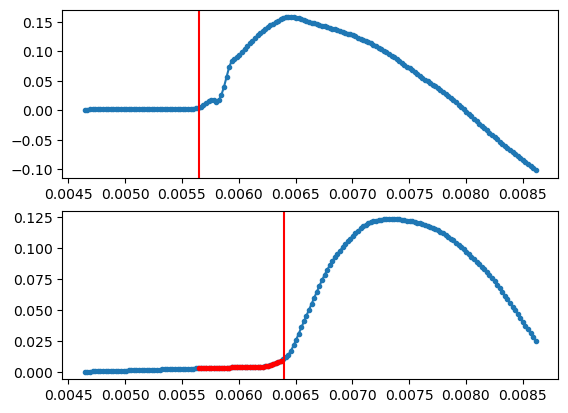

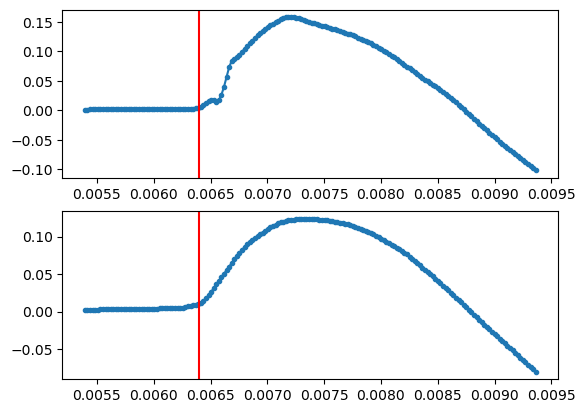

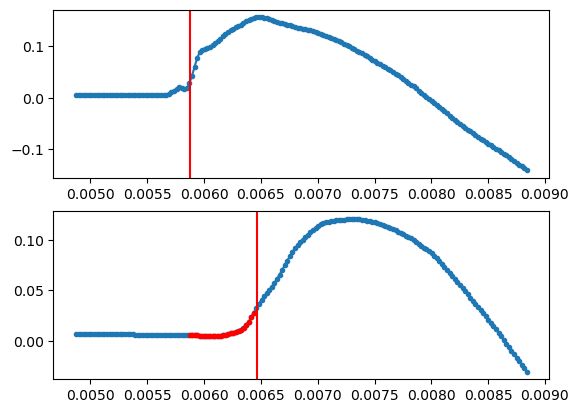

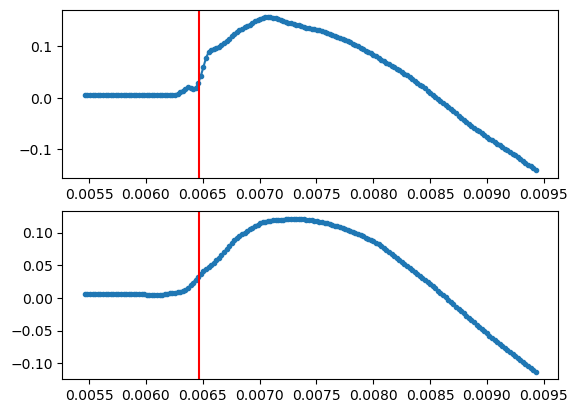

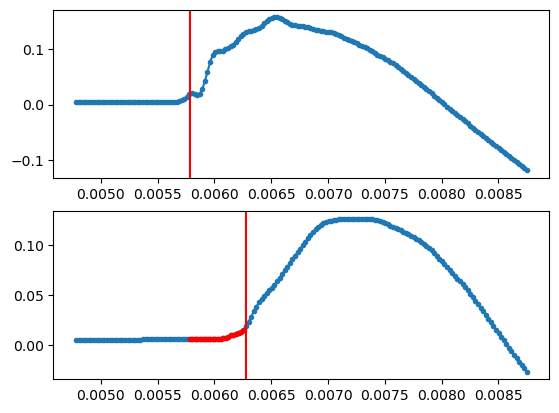

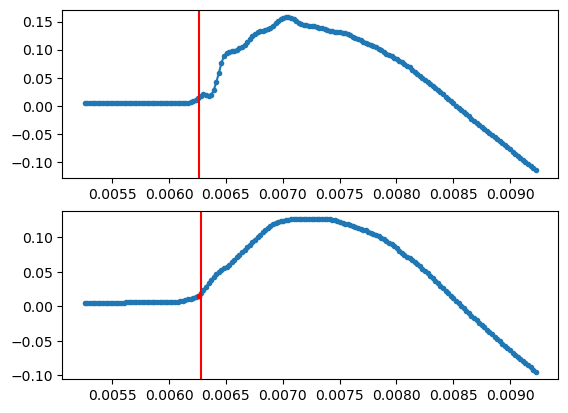

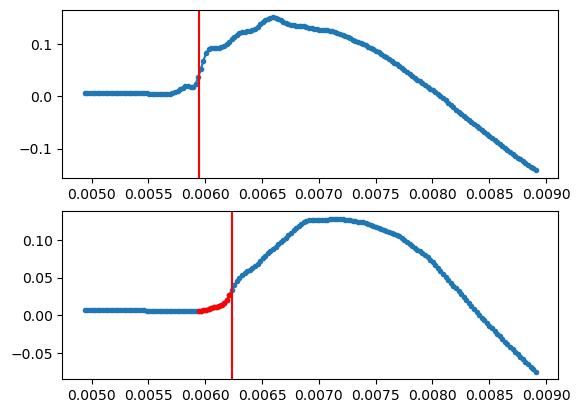

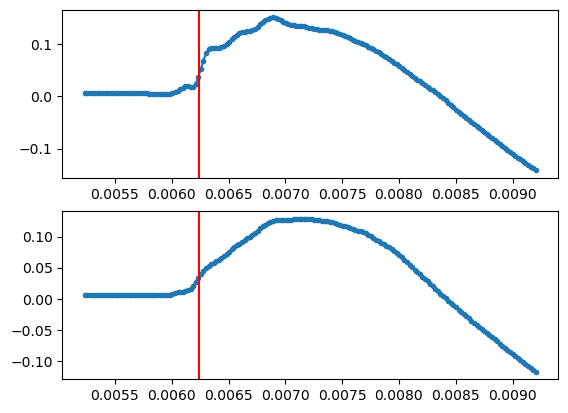

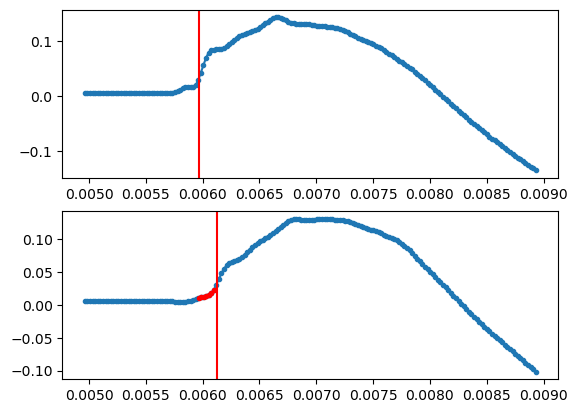

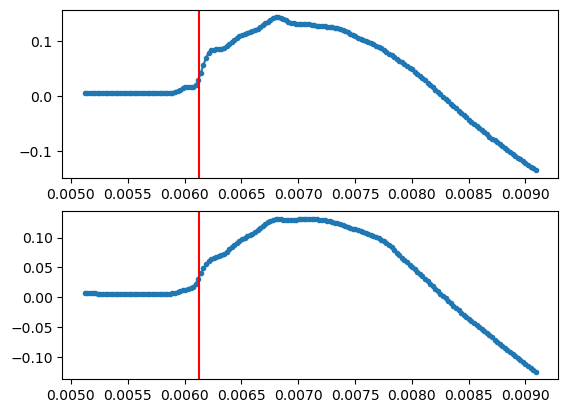

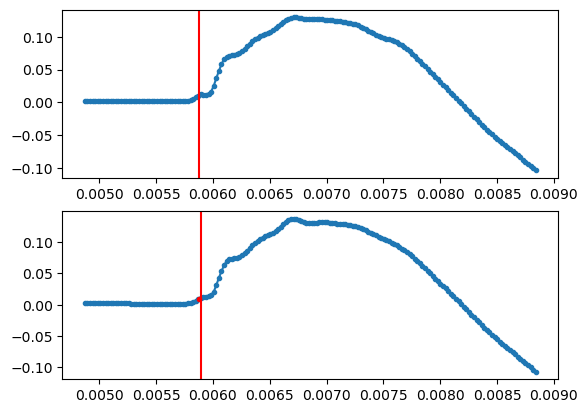

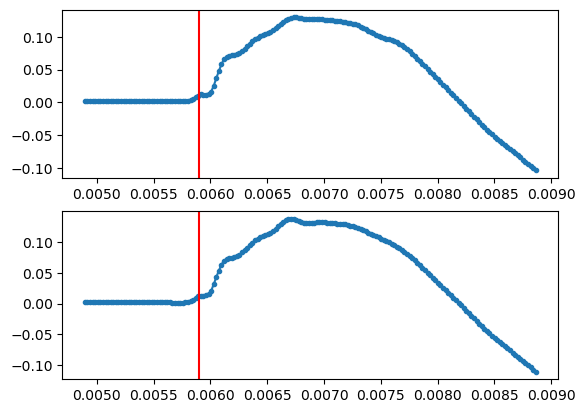

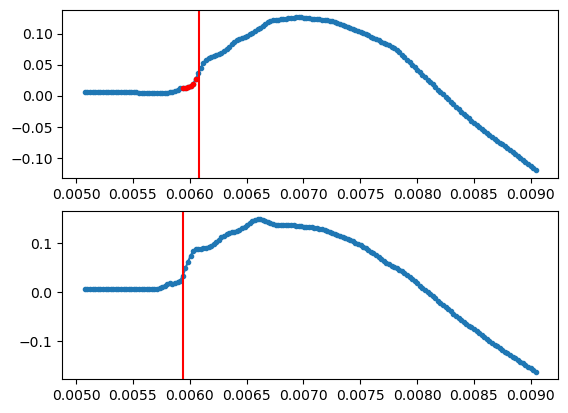

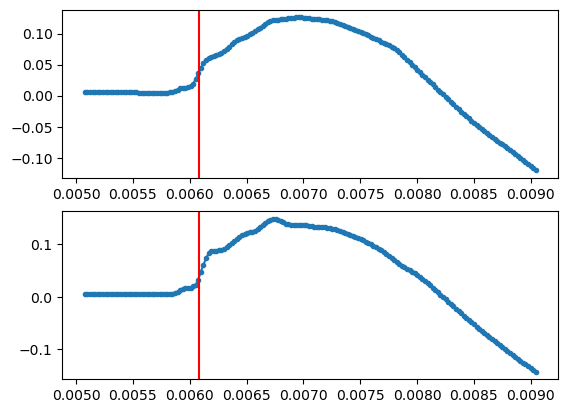

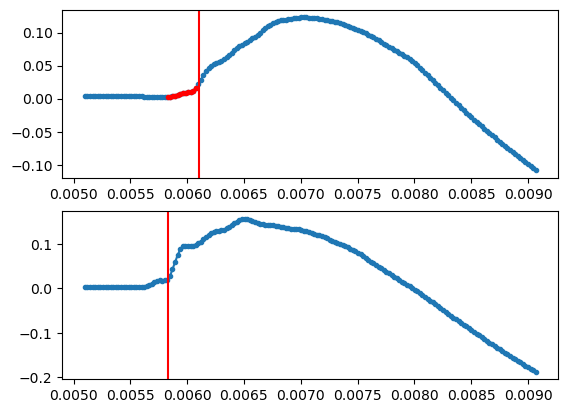

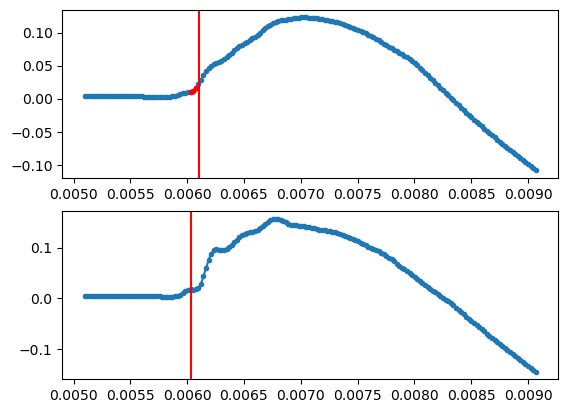

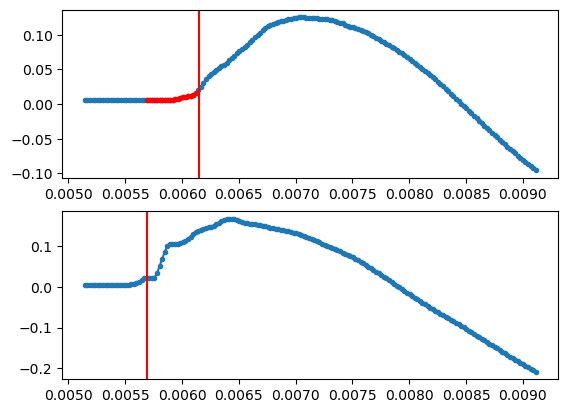

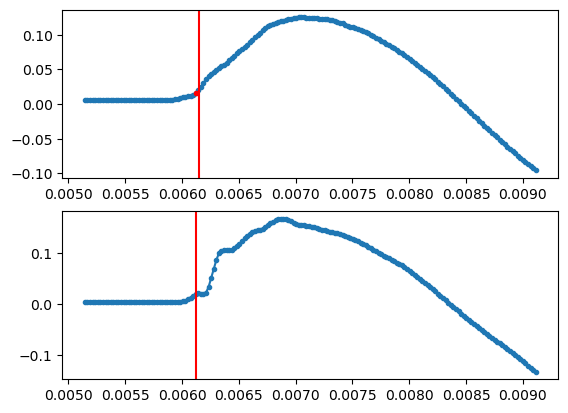

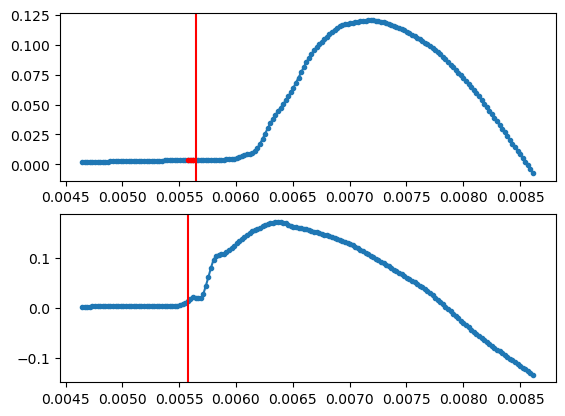

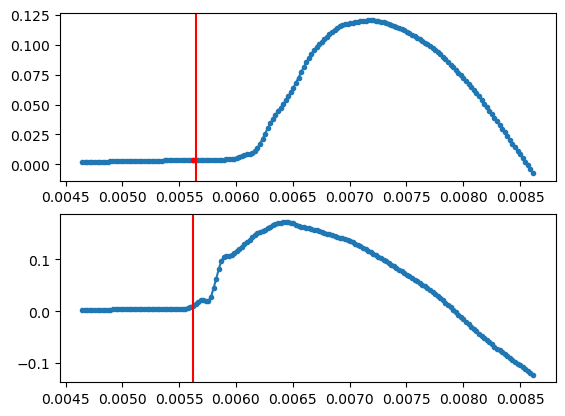

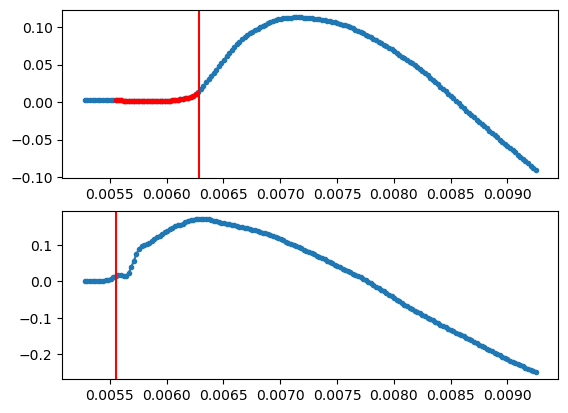

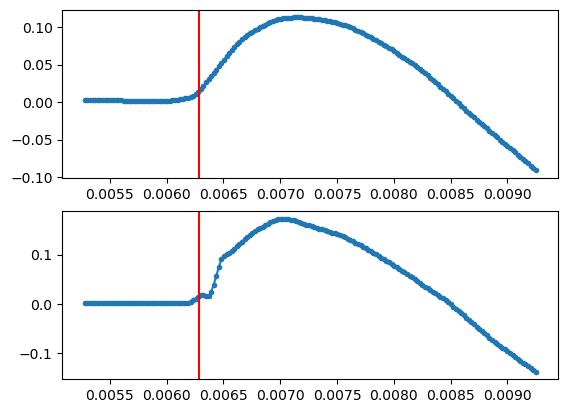

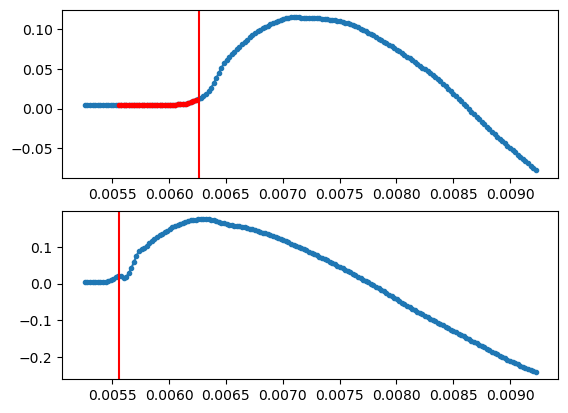

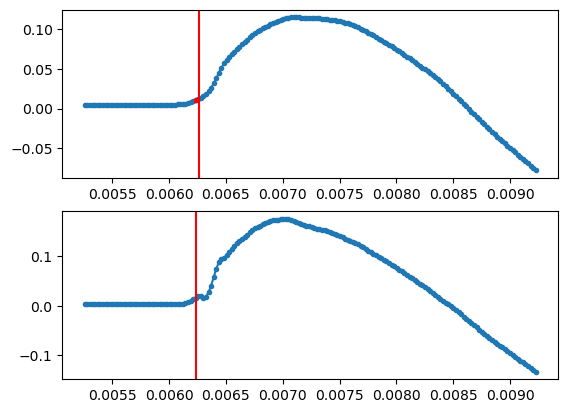

In [3]:
print("WHEN USING HRTF ESTIMATE")
for ANGLE in range(-90,91,15):
    logger.setLevel(logging.WARNING)
    itd = run_hrtf(sound,ANGLE,{
                        "subj_number": 7,
                        "ild_only": True,
                        "itd_remove_strategy": ITD_REMOVAL_STRAT.ESTIMATE_FROM_HRTF,
                        "show_ITD_plots": True
                    }, )
    print(itd)